In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import linalg

import pylops

# Description of the matrix approach 

For real data we have

$\left[ \tilde{f}^T \tilde{f} + R^T T \right] x = \tilde{f}^T y$

where $\tilde{f} = D f$ is a real matrix of shape ($n_p$, $n_s$). $f$ is a real matrix of shape ($n_p$, $n_s$) and $D$ is the convolution which is a real matrix of shape ($n_p$, $n_p$).

For complex data we instead 

$\left[ \tilde{f_{\Re}}^T \tilde{f_{\Re}} + \tilde{f_{\Im}}^T \tilde{f_{\Im}} \right] x = \tilde{f_{\Re}}^T y_{\Re} + \tilde{f_{\Im}}^T y_{\Im}$

where $\tilde{f} = D f$ is a compex matrix of shape ($n_v$, $n_s$). $f$ is a real matrix of shape ($n_p$, $n_s$) and $D$ is the non-uniform fast fourier transform (NUFFT) which is a complex matrix of shape ($n_v$, $n_p$).

$ (\tilde{f_{\Re}}^T \tilde{f_{\Re}})^{-1} \tilde{f_{\Re}}^T y_{\Re} \ne (\tilde{f_{\Im}}^T \tilde{f_{\Im}})^{-1} \tilde{f_{\Im}}^T y_{\Im}$

In our matrix approach, regularization is applied after we sum the real and imag components

$\left[ \left(\tilde{f_{\Re}}^T \tilde{f_{\Re}} + \tilde{f_{\Im}}^T \tilde{f_{\Im}} \right) + R^T R \right] x = \tilde{f_{\Re}}^T y_{\Re} + \tilde{f_{\Im}}^T y_{\Im}$

To summarize, in our matrix approach, the solution $x$ is always real as the matrix inversion is performed with "real" matrices, which have been constructed from the sum of the real and imag compponents of a originaly complex matrix.

| Object | Dimension | Description |
|------|------|------|
|   $n_v$  | - | # of visibilities |
|   $n_p$  | - | # of image-plane pixels |
|   $n_s$  | - | # of source-plane pixels |

# Pylops 

In [8]:
def NormalEquationsInversion_method_1(
    Op_real, 
    Op_imag, 
    data_real, 
    data_imag, 
    returninfo=False, 
    **kwargs_cg
):

    OpH_real = Op_real.H
    OpH_imag = Op_imag.H

    Op_normal_real = OpH_real * Op_real
    Op_normal_imag = OpH_imag * Op_imag
    Op_normal = (Op_normal_real + Op_normal_imag)

    y_normal_real = OpH_real * data_real
    y_normal_imag = OpH_imag * data_imag
    y_normal = y_normal_real + y_normal_imag

    xinv, istop = linalg.cg(Op_normal, y_normal, **kwargs_cg)

    if returninfo:
        return xinv, istop
    else:
        return xinv
    
def NormalEquationsInversion_method_2(
    Op, 
    data, 
    returninfo=False, 
    **kwargs_cg
):

    OpH = Op.H

    Op_normal = OpH * Op

    y_normal = OpH * data

    xinv, istop = linalg.cg(Op_normal, y_normal, **kwargs_cg)

    if returninfo:
        return xinv, istop
    else:
        return xinv

# Tools

In [9]:
def a_complex_from_a_real_and_a_imag(
    a_real, 
    a_imag
):
    # convert a numpy array of shape (n, 2) to a complex array of shape (n, )

    a_complex = np.stack(
        arrays=(a_real, a_imag), axis=-1
    )

    a_complex = np.apply_along_axis(
        lambda args: [complex(*args)], len(a_complex.shape) - 1, a_complex
    ).astype("complex128")

    return np.squeeze(a_complex)

# Example

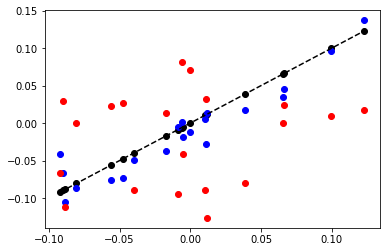

In [10]:
N_vis = 100
N_grid = 400
N_src = 20

#f_real = np.random.normal(0.0, 1.0, size=(N_grid, N_src))
#f_imag = np.random.normal(0.0, 1.0, size=(N_grid, N_src))

f_fft_real = np.random.normal(0.0, 1.0, size=(N_vis, N_src))
f_fft_imag = np.random.normal(0.0, 1.0, size=(N_vis, N_src))

F_real = np.dot(f_fft_real.T, f_fft_real)
F_imag = np.dot(f_fft_imag.T, f_fft_imag)

d_real = np.random.normal(0.0, 1.0, size=(N_vis, ))
d_imag = np.random.normal(0.0, 1.0, size=(N_vis, ))

D_real = np.dot(f_fft_real.T, d_real)
D_imag = np.dot(f_fft_imag.T, d_imag)

# NOTE: This is the linear system Ax = y we are solving in our matrix approach.
x = np.linalg.solve(
    F_real + F_imag, 
    D_real + D_imag
)

# NOTE: For real problems D_real != D_imag & F_real != F_imag, therefore there is not
# a single "real" vector x that satisfies both. 
# NOTE: This is in respose to https://github.com/PyLops/pylops_notebooks/blob/master/developement/ComplexMatmul.ipynb
x_real = np.linalg.solve(F_real, D_real)
x_imag = np.linalg.solve(F_imag, D_imag)

# NOTE: Method 1
f_fft_real_lops = pylops.MatrixMult(f_fft_real, dtype='float64')
f_fft_imag_lops = pylops.MatrixMult(f_fft_imag, dtype='float64')

x_lops_method_1 = NormalEquationsInversion_method_1(
    Op_real=f_fft_real_lops,
    Op_imag=f_fft_imag_lops,
    data_real=d_real,
    data_imag=d_imag
)

# NOTE: Method 2
f_fft_complex = a_complex_from_a_real_and_a_imag(
    a_real=f_fft_real, 
    a_imag=f_fft_imag
)
f_fft_complex_lops = pylops.MatrixMult(
    f_fft_complex, dtype="complex128"
)

d_complex = a_complex_from_a_real_and_a_imag(
    a_real=d_real, a_imag=d_imag
)

x_lops_method_2 = NormalEquationsInversion_method_2(
    Op=f_fft_complex_lops,
    data=d_complex
)

plt.figure()
plt.plot(x, x_lops_method_1, linestyle="None", marker="o", color="black")
plt.plot(x, x_lops_method_2.real, linestyle="None", marker="o", color="b")
plt.plot(x, x_lops_method_2.imag, linestyle="None", marker="o", color="r")
#plt.plot(x_real, x_lops_method_2.real, linestyle="None", marker="s", color="b")
#plt.plot(x_imag, x_lops_method_2.imag, linestyle="None", marker="s", color="r")
x_min = np.min(x)
x_max = np.max(x)
plt.plot(
    np.linspace(x_min, x_max, 10),
    np.linspace(x_min, x_max, 10),
    linestyle="--",
    color="black"
)
plt.show()